## Week 8 task by Denis Khryashchev

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path
from sklearn import manifold
import matplotlib.image as mpimg
from matplotlib import offsetbox
%matplotlib inline

In [2]:
# URL of the data and its local name
CSV_URL = "https://pjreddie.com/media/files/mnist_train.csv"
local_csv = "mnist_train.csv"

In [3]:
# Checking if we have already downloaded the data
if not os.path.isfile("mnist_train.csv"):
    pd.read_csv(CSV_URL, header = None).to_csv("mnist_train.csv")

In [4]:
# Loading the dataset iteratively, filtering only digit '0'
csv_iterator = pd.read_csv(local_csv, iterator = True, chunksize = 5000)
zero = pd.concat([portion[portion[portion.columns[1]] == 0] for portion in csv_iterator])

In [5]:
# Dropping the extra index and the label columns
zero = zero.drop(zero.columns[0], axis = 1)
zero = zero.drop(zero.columns[0], axis = 1)

# Proper indexing
zero = zero.reset_index(drop = True)

# Taking exactly 5000 observations
zero = zero.head(5000)

In [6]:
print len(zero)
zero.tail(5)

5000


,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Creating the numpy array for ICA and clustering
X = zero.as_matrix()

In [8]:
len(X)

5000

In [9]:
# MDS  embedding of the digits dataset
clf = manifold.MDS(n_components = 2, n_init = 1, max_iter = 100)
X_proj = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)

Done. Stress: 10616558571506.308594


In [10]:
# Calculating the size of the grid for Hilbert mapping
X_proj_T = np.transpose(X_proj)
min_x = np.min(X_proj_T[0])
max_x = np.max(X_proj_T[0])
min_y = np.min(X_proj_T[1])
max_y = np.max(X_proj_T[1])
n = int(round(max((max_x - min_x) / 28, (max_y - min_y) / 28)))
min_x = int(round(min_x))
min_y = int(round(min_y))
max_x = int(round(max_x))
max_y = int(round(max_y))
print "x between", min_x, max_x
print "y between", min_y, max_y
print "Grid size:", n

x between -2720 2723
y between -2611 3029
Grid size: 201


In [11]:
# Function to map the data onto 204x204 grid
def coord2grid(xy, min_x, min_y):
    x = (int(round(xy[0])) - min_x) // 28
    y = (int(round(xy[1])) - min_y) // 28
    return [int(x), int(y)]

In [12]:
# Mapping
mappings = map(list, map(lambda i: [i] + coord2grid(X_proj[i], min_x, min_y), range(len(X_proj))))

In [13]:
# Checking the correctness of the mapping
print min(mappings, key = lambda x: x[1])[1], max(mappings, key = lambda x: x[1])[1]
print min(mappings, key = lambda y: y[2])[2], max(mappings, key = lambda y: y[2])[2]

0 194
0 201


In [14]:
mappings[:5]

[[0, 101, 71], [1, 87, 62], [2, 91, 18], [3, 137, 52], [4, 49, 85]]

In [15]:
# Function to map X,Y to 1D Hilbert Index (Hilbert Curve)
def xy2d (n, x, y):
    x = int(round(x))
    y = int(round(y))
    def rotate(n, x, y, rx, ry):
        if ry == 0:
            if rx == 1:
                x = n - 1 - x
                y = n - 1 - y
            x, y = y, x
            
        return x, y
    
    d = 0
    s = n
    
    while s > 0:
        s = s//2
        rx = (x & s) > 0
        ry = (y & s) > 0
        d += s * s * ((3 * rx) ^ ry)
        x, y = rotate(s, x, y, rx, ry)  
        
    return d

In [25]:
# Calculating the Hilbert's D
mappings = map(lambda i: mappings[i] + [xy2d(n, mappings[i][1], mappings[i][2])], range(len(mappings)))

In [27]:
# Sorting with Hilbert's D
mappings = sorted(mappings, key = lambda x: x[-1])

In [30]:
min(mappings, key = lambda x: x[-1]), max(mappings, key = lambda x: x[-1])

([1478, 128, 129, 635], [1279, 151, 146, 39853])

In [31]:
mappings[:5]

[[1478, 128, 129, 635],
 [3552, 128, 129, 635],
 [1455, 131, 128, 3254],
 [2086, 138, 128, 3314],
 [2168, 26, 128, 3314]]

In [34]:
X_proj[1478], X_proj[3552]

(array([ 878.65112068, 1015.88563556]), array([ 880.04240217, 1005.64886867]))

In [16]:
def plot_components(data, proj):
    
    fig, ax = plt.subplots(figsize = (18, 18))
    
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    images = data.reshape(5000, 28, 28)
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(images[100], cmap = "gray_r"),
                              proj[100])
    ax.add_artist(imagebox)

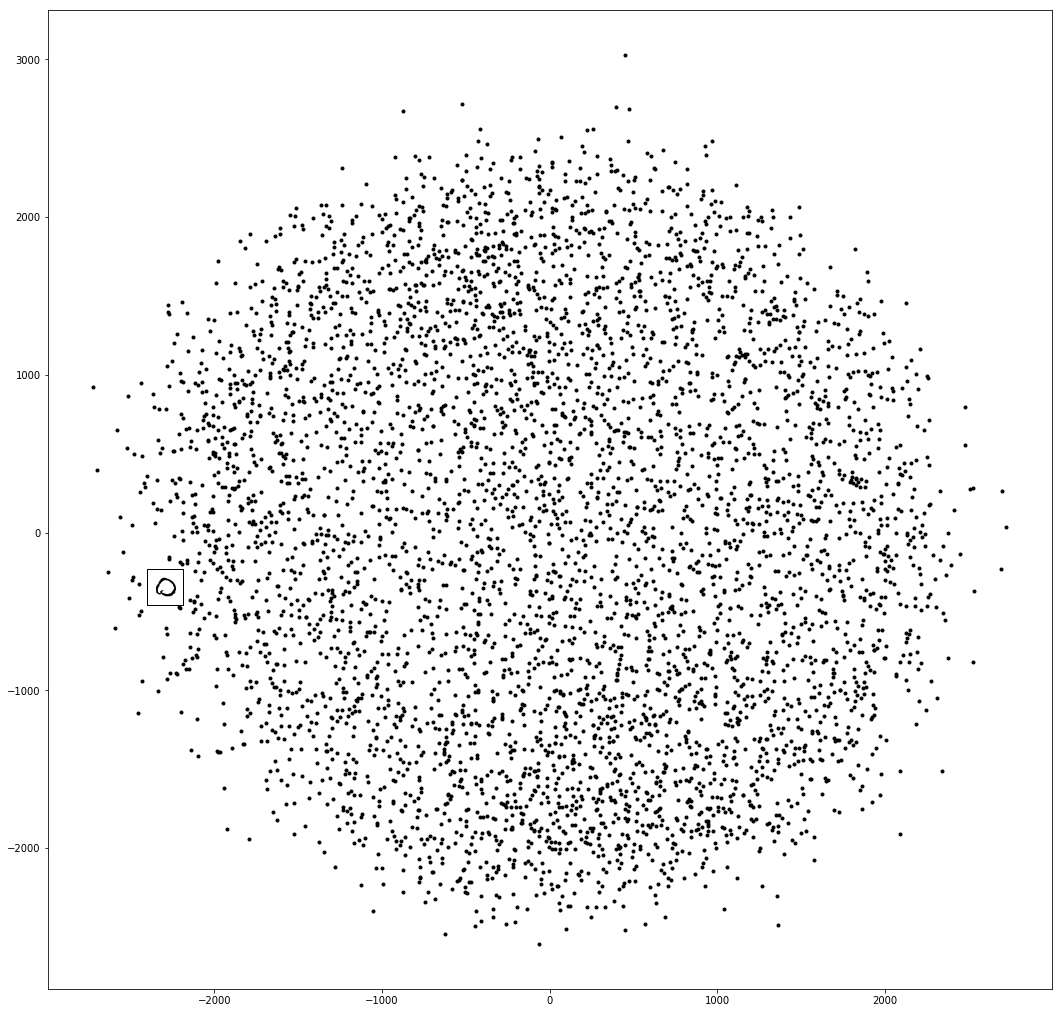

In [18]:
plot_components(X, X_proj)

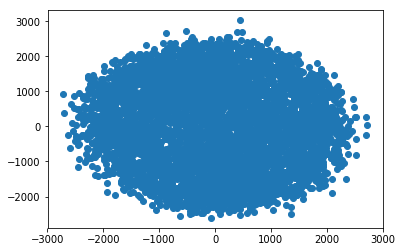

In [19]:
plt.scatter(np.transpose(X_proj)[0], np.transpose(X_proj)[1])

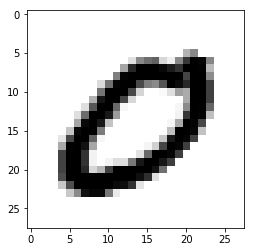

In [20]:
plt.imshow(X[55].reshape(28, 28), cmap='gray_r')